<p align="center">
    <a href="https://predict-idlab.github.io/landmarker">
        <img alt="landmarker" src="https://raw.githubusercontent.com/predict-idlab/landmarker/main/docs/_static/images/logo.svg" width="66%">
    </a>
</p>

# Training and Evaluating One-hot Encoded (Mask) Regression Model for Landmark Localizatioin on MML (3D)

In this tutorial, we will train and evaluate an one-hot encoded (mask) regression model for landmark 
localization on MML. The Mandibular Molar Landmarking (MML) dataset, which consists of 658
annotated CT volumes of the skull. The CT volumes are transformed to a uniform scale of 512 × 512 × 256. Multiple
junior and senior clinicians annotated the CT volumes. It includes 14 mandibular landmarks, specifically, 4 crowns, 8
roots of the second and third mandibular molars, and 2 cups of cuspids. Note that the number of landmarks in a single CT
volume is arbitrary, i.e., some landmarks are absent in the images. We filter out all CT volumes where not all landmarks are present, reducing the dataset size to 399.

We will go through the following steps:
* [Loading the dataset](#Loading-the-dataset)
* [Inspecting the dataset](#Inspecting-the-dataset)
* [Training and initializing the UNet model](#Training-the-model)
* [Evaluating the model](#Evaluating-the-model)

<a target="_blank" href="https://colab.research.google.com/github/predict-idlab/landmarker/examples/3D-example-MML-maskdataset.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Setup environment

In [1]:
# !python -c "import landmarker" || pip install landmarker

import sys
import os

sys.path.append("../src/")
import landmarker

## Setup imports and variables

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

## Loading the dataset

### Short description of the data and dataset module
The [landmarker](https://github.com/predict-idlab/landmarker) package has several built-in
datasets in the `landmarker.datasets` module, as well as utility classes for building your own
datasets in the `landmarker.data` module. There are three types of datasets: 'LandmarkDataset',
'HeatmapDataset', and 'MaskDataset'. The 'LandmarkDataset' is a dataset of images with landmarks,
the 'HeatmapDataset' is a dataset of images with heatmaps, and the 'MaskDataset' is a dataset of
images with masks (i.e., binary segmentation masks indiciating the location of the landmarks). The 
'HeatmapDataset' and 'MaskDataset' both inherit from the 'LandmarkDataset' class, and thus also 
contain information about the landmarks. The 'MaskDataset' can be constructed from specified image 
and landmarks pairs, or from images and masks pairs, because often that is how the data is
distributed. The 'HeatmapDataset' can be constructed from images and landmarks pairs.

Images can be provided as a list of paths to stored images, or as a a numpy arary, torch tensor, 
list of numpy  arrays or list of torch tensors. Landmarks can be as numpy arrays or torch tensors.
These landmarks can be provided in three different shapes: (1) (N, D) where N is the number of
samples and D is the number of dimensions, (2) (N, C, D) where C is the number of landmark
classes, (3) (N, C, I, D) where I is the number of instances per landmark class, if less than I
instances are provided, the remaining instances are filled with NaNs.

In [4]:
from monai.transforms import (Compose, ScaleIntensityd)

fn_keys = ('image', 'mask')
spatial_transformd = []

train_transformd = Compose([
                            ScaleIntensityd(('image', )),  # Scale intensity
                        ] + spatial_transformd)

inference_transformd = Compose([
    ScaleIntensityd(('image', )),
])

In [ ]:
from glob import glob

path_data = "..."

# Warning ensure that lists of paths for volumes, landmarks, and pixel_spacings

# volume paths
volume_paths_train = sorted(glob(f"{path_data}/train/*_volume.npy"))
volume_paths_val = sorted(glob(f"{path_data}/val/*_volume.npy"))
volume_paths_test = sorted(glob(f"{path_data}/test/*_volume.npy"))

# landmark paths and transform to single numpy arrays for each set
landmarks_paths_train = sorted(glob(f"{path_data}/train/*_label.npy"))
landmarks_train = np.stack([np.load(path) for path in landmarks_paths_train])
landmarks_paths_val = sorted(glob(f"{path_data}/val/*_label.npy"))
landmarks_val = np.stack([np.load(path) for path in landmarks_paths_val])
landmarks_paths_test = sorted(glob(f"{path_data}/test/*_label.npy"))
landmarks_test = np.stack([np.load(path) for path in landmarks_paths_test])

# voxel spacing paths and transform to single numpy arrays for each set
spacing_paths_train = sorted(glob(f"{path_data}/train/*_spacing.npy"))
pixel_spacings_train = np.stack([np.load(path) for path in spacing_paths_train])
spacing_paths_val = sorted(glob(f"{path_data}/val/*_spacing.npy"))
pixel_spacings_val = np.stack([np.load(path) for path in spacing_paths_val])
spacing_paths_test = sorted(glob(f"{path_data}/test/*_spacing.npy"))
pixel_spacings_test = np.stack([np.load(path) for path in spacing_paths_test])


In [7]:
dim_img = (128, 128, 64)

In [8]:
from landmarker.data import MaskDataset

ds_train = MaskDataset(
    imgs=volume_paths_train,
    landmarks=landmarks_train,
    spatial_dims=3,
    pixel_spacing=pixel_spacings_train,
    transform=train_transformd,
    store_imgs=False,
    dim_img=dim_img
)

ds_val = MaskDataset(
    imgs=volume_paths_val,
    landmarks=landmarks_val,
    spatial_dims=3,
    pixel_spacing=pixel_spacings_val,
    transform=inference_transformd,
    store_imgs=False,
    dim_img=dim_img
)

ds_test = MaskDataset(
    imgs=volume_paths_test,
    landmarks=landmarks_test,
    spatial_dims=3,
    pixel_spacing=pixel_spacings_test,
    transform=inference_transformd,
    store_imgs=False,
    dim_img=dim_img
)

## Inspecting the dataset

In [9]:
batch = ds_train[0]

In [10]:
# %pip install 'napari[all]'
# %pip install 'ipyvolume'

### Visualize 3D Image + Landmarks

In [11]:
import napari
import numpy as np


viewer = napari.Viewer(ndisplay=3)

viewer.add_image(batch["image"][0])

# Add landmarks (as points layer)
viewer.add_points(
    batch["landmark"],
    size=5,
    face_color="red",
    name="landmarks"
)

napari.run()


In [14]:
import ipyvolume as ipv
import numpy as np

# Show volume
ipv.quickvolshow(batch["image"][0], level=[0.3, 0.6], opacity=0.03)

# Extract xyz coords
z, y, x = batch["landmark"].T

# Plot landmarks
ipv.scatter(x, y, z, color="red", size=5, marker="sphere")

ipv.show()

/opt/anaconda3/envs/vision/lib/python3.10/site-packages/ipyvolume/serialize.py:102: RuntimeWarning: invalid value encountered in cast
  subdata[..., i] = ((gradient[i][zindex] / 2.0 + 0.5) * 255).astype(np.uint8)


Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.3, max=1.0, step…

### Visualize 3D Image + Masks + Landmarks

In [18]:
import napari

# Launch viewer
viewer = napari.Viewer(ndisplay=3)

# Add base volume
viewer.add_image(batch["image"][0], name="volume")

# Add landmarks (as points layer)
viewer.add_points(
    batch["landmark"],
    size=2,
    face_color="blue",
    name="landmarks"
)

# Add each channel as a label layer (colored mask)
for c in range(14):
    viewer.add_labels(batch["mask"][c].int(), name=f"landmark_{c}")

napari.run()

## Training and initializing the Unet model

### Initializing the model, optimizer and loss function

In [ ]:
from monai.networks.nets import FlexibleUNet
from landmarker.losses import NLLLoss
from landmarker.models.utils import SoftmaxND

model = FlexibleUNet(
                    in_channels=1,
                    out_channels=14, # nb of landmarks
                    backbone="efficientnet-b0",
                    pretrained=True,
                    decoder_channels=[128, 128, 128, 128, 128],
                    spatial_dims=3,
                    norm="batch",
                    act="relu",
                    dropout=0.5,
                    decoder_bias=False,
                    upsample="nontrainable",
                    pre_conv="default",
                    interp_mode="nearest",
                    is_pad=True,
                    ).to(device)
print("Number of learnable parameters: {}".format(
    sum(p.numel() for p in model.parameters() if p.requires_grad)))
lr = 1e-5
batch_size = 1
epochs = 60

optimizer = torch.optim.Adam(
            [
                {"params": model.parameters()},
            ],
            lr=lr,
)


criterion = NLLLoss(spatial_dims=3)

decoder_method = "argmax"

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                          patience=10, cooldown=10)

Number of learnable parameters: 10630738


### Setting the data loaders

In [9]:
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=4)

### Training the model

In [10]:
from landmarker.heatmap.decoder import heatmap_to_coord
from landmarker.metrics import point_error

def train_epoch(model, train_loader, criterion, optimizer, device):
    running_loss = 0
    model.train()
    for i, batch in enumerate(tqdm(train_loader)):
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10000.0)
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def val_epoch(model, val_loader, criterion, device, method="argmax"):
    eval_loss = 0
    eval_mpe = 0
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(val_loader)):
            images = batch["image"].to(device)
            outputs = model(images)
            dim_orig = batch["dim_original"].to(device)
            pixel_spacing = batch["spacing"].to(device)
            padding = batch["padding"].to(device)
            masks = batch["mask"].to(device)
            landmarks = batch["landmark"].to(device)
            loss = criterion(outputs, masks)
            pred_landmarks = heatmap_to_coord(outputs, method=method, spatial_dims=3)
            eval_loss += loss.item()
            eval_mpe += point_error(landmarks, pred_landmarks, images.shape[-3:], dim_orig,
                                    pixel_spacing, padding, reduction="mean")
    return eval_loss / len(val_loader), eval_mpe / len(val_loader)

def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=1000):
    for epoch in tqdm(range(epochs)):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_mpe = val_epoch(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f} - Val mpe: {val_mpe:.4f}")
        lr_scheduler.step(val_loss)

In [11]:
train(model, train_loader, val_loader, criterion, optimizer, device,
      epochs=epochs)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/60 - Train loss: 13.6618 - Val loss: 13.8672 - Val mpe: 61.5504


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2/60 - Train loss: 13.0834 - Val loss: 13.8411 - Val mpe: 65.8023


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3/60 - Train loss: 12.6250 - Val loss: 13.2749 - Val mpe: 31.9457


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 4/60 - Train loss: 12.0499 - Val loss: 11.4506 - Val mpe: 25.9390


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 5/60 - Train loss: 11.1521 - Val loss: 9.7715 - Val mpe: 20.8436


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 6/60 - Train loss: 10.0226 - Val loss: 8.4791 - Val mpe: 13.2843


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 7/60 - Train loss: 9.1855 - Val loss: 7.8617 - Val mpe: 11.9547


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 8/60 - Train loss: 8.7283 - Val loss: 7.6428 - Val mpe: 11.1689


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 9/60 - Train loss: 8.4043 - Val loss: 7.2731 - Val mpe: 9.5265


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10/60 - Train loss: 8.2231 - Val loss: 7.1468 - Val mpe: 8.4783


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 11/60 - Train loss: 7.9650 - Val loss: 6.9264 - Val mpe: 6.8929


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 12/60 - Train loss: 7.7510 - Val loss: 6.7333 - Val mpe: 6.3739


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 13/60 - Train loss: 7.5878 - Val loss: 6.5279 - Val mpe: 4.9365


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 14/60 - Train loss: 7.4038 - Val loss: 6.3934 - Val mpe: 4.3503


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 15/60 - Train loss: 7.2421 - Val loss: 6.3310 - Val mpe: 4.1600


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 16/60 - Train loss: 7.1283 - Val loss: 6.2296 - Val mpe: 3.7022


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 17/60 - Train loss: 6.9824 - Val loss: 6.0946 - Val mpe: 3.4488


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 18/60 - Train loss: 6.9375 - Val loss: 6.0371 - Val mpe: 3.1495


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 19/60 - Train loss: 6.7439 - Val loss: 5.9845 - Val mpe: 3.0110


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 20/60 - Train loss: 6.6657 - Val loss: 5.9516 - Val mpe: 2.9364


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 21/60 - Train loss: 6.5495 - Val loss: 5.8250 - Val mpe: 2.7313


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 22/60 - Train loss: 6.4666 - Val loss: 5.8044 - Val mpe: 2.7353


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 23/60 - Train loss: 6.3349 - Val loss: 5.7169 - Val mpe: 2.6575


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 24/60 - Train loss: 6.3021 - Val loss: 5.6797 - Val mpe: 2.6324


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 25/60 - Train loss: 6.2152 - Val loss: 5.6592 - Val mpe: 2.6078


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 26/60 - Train loss: 6.1469 - Val loss: 5.6394 - Val mpe: 2.7124


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 27/60 - Train loss: 6.0800 - Val loss: 5.5844 - Val mpe: 2.5731


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 28/60 - Train loss: 6.0143 - Val loss: 5.5765 - Val mpe: 2.5272


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 29/60 - Train loss: 5.9978 - Val loss: 5.5436 - Val mpe: 2.4605


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 30/60 - Train loss: 5.9355 - Val loss: 5.5833 - Val mpe: 2.5290


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 31/60 - Train loss: 5.8256 - Val loss: 5.4766 - Val mpe: 2.3692


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 32/60 - Train loss: 5.8370 - Val loss: 5.4891 - Val mpe: 2.4370


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 33/60 - Train loss: 5.7940 - Val loss: 5.4510 - Val mpe: 2.3741


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 34/60 - Train loss: 5.6998 - Val loss: 5.4596 - Val mpe: 2.4630


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 35/60 - Train loss: 5.6500 - Val loss: 5.4451 - Val mpe: 2.4061


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 36/60 - Train loss: 5.5799 - Val loss: 5.4039 - Val mpe: 2.2553


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 37/60 - Train loss: 5.5267 - Val loss: 5.3885 - Val mpe: 2.2276


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 38/60 - Train loss: 5.4954 - Val loss: 5.3974 - Val mpe: 2.4512


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 39/60 - Train loss: 5.4204 - Val loss: 5.3822 - Val mpe: 2.4493


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 40/60 - Train loss: 5.4198 - Val loss: 5.4089 - Val mpe: 2.3253


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 41/60 - Train loss: 5.3810 - Val loss: 5.3777 - Val mpe: 2.3584


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 42/60 - Train loss: 5.3267 - Val loss: 5.3954 - Val mpe: 2.3004


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 43/60 - Train loss: 5.2859 - Val loss: 5.3714 - Val mpe: 2.2624


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 44/60 - Train loss: 5.2517 - Val loss: 5.3506 - Val mpe: 2.3085


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 45/60 - Train loss: 5.2162 - Val loss: 5.3774 - Val mpe: 2.4262


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 46/60 - Train loss: 5.1680 - Val loss: 5.3671 - Val mpe: 2.3427


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 47/60 - Train loss: 5.1511 - Val loss: 5.3600 - Val mpe: 2.2358


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 48/60 - Train loss: 5.0686 - Val loss: 5.3624 - Val mpe: 2.1927


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 49/60 - Train loss: 5.0631 - Val loss: 5.4156 - Val mpe: 2.3349


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 50/60 - Train loss: 5.0215 - Val loss: 5.3805 - Val mpe: 2.2567


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 51/60 - Train loss: 4.9756 - Val loss: 5.3894 - Val mpe: 2.2176


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 52/60 - Train loss: 4.9549 - Val loss: 5.3873 - Val mpe: 2.1362


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 53/60 - Train loss: 4.8994 - Val loss: 5.3969 - Val mpe: 2.2065


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 54/60 - Train loss: 4.8777 - Val loss: 5.4026 - Val mpe: 2.0645


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 55/60 - Train loss: 4.8202 - Val loss: 5.4019 - Val mpe: 2.1457


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 56/60 - Train loss: 4.7835 - Val loss: 5.4449 - Val mpe: 2.1925


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 57/60 - Train loss: 4.7842 - Val loss: 5.4435 - Val mpe: 2.1724


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 58/60 - Train loss: 4.7428 - Val loss: 5.4447 - Val mpe: 2.1622


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 59/60 - Train loss: 4.7937 - Val loss: 5.4324 - Val mpe: 2.1657


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 60/60 - Train loss: 4.7140 - Val loss: 5.4536 - Val mpe: 2.1793


In [ ]:
# torch.save(model.state_dict(), "3D-mml-one-hot-unet.pt")

## Evaluating the model

In [ ]:
# model.load_state_dict(torch.load("3D-mml-one-hot-unet.pt", weights_only=True))

In [12]:
pred_landmarks_test = []
true_landmarks_test = []
dim_origs_test = []
pixel_spacings_test = []
paddings_test = []
test_mpe = 0
model.eval()
model.to(device)
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        images = batch["image"].to(device)
        outputs = model(images)
        dim_orig = batch["dim_original"].to(device)
        pixel_spacing = batch["spacing"].to(device)
        padding = batch["padding"].to(device)
        landmarks = batch["landmark"].to(device)
        pred_landmark = heatmap_to_coord(outputs, method="argmax", spatial_dims=3)
        test_mpe += point_error(landmarks, pred_landmark, images.shape[-3:], dim_orig,
                                pixel_spacing, padding, reduction="mean")
        pred_landmarks_test.append(pred_landmark.cpu())
        true_landmarks_test.append(landmarks.cpu())
        dim_origs_test.append(dim_orig.cpu())
        pixel_spacings_test.append(pixel_spacing.cpu())
        paddings_test.append(padding.cpu())

pred_landmarks_test = torch.cat(pred_landmarks_test)
true_landmarks_test = torch.cat(true_landmarks_test)
dim_origs_test = torch.cat(dim_origs_test)
pixel_spacings_test = torch.cat(pixel_spacings_test)
paddings_test = torch.cat(paddings_test)

test_mpe /= len(test_loader)

print(f"Test Mean PE: {test_mpe:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Test Mean PE: 2.5072


In [13]:
from landmarker.metrics import sdr

sdr_test = sdr([2.0, 2.5, 3.0, 4.0], true_landmarks=true_landmarks_test, pred_landmarks=pred_landmarks_test,
               dim=dim_img, dim_orig=dim_origs_test.int(), pixel_spacing=pixel_spacings_test, padding=paddings_test)

print("Results on Test Set:")
for key in sdr_test:
    print(f"SDR for {key}mm: {sdr_test[key]:.4f}")

Results on Test Set:
SDR for 2.0mm: 68.2143
SDR for 2.5mm: 78.3571
SDR for 3.0mm: 81.2143
SDR for 4.0mm: 86.2143


In [14]:
from landmarker.visualize import detection_report

print("Test Set")
detection_report(true_landmarks_test, pred_landmarks_test, dim=dim_img, dim_orig=dim_origs_test.int(),
                    pixel_spacing=pixel_spacings_test, padding=paddings_test, class_names=ds_test.class_names,
                    radius=[2.0, 2.5, 3.0, 4.0], digits=2)

Test Set
Detection report:
1# Point-to-point error (PE) statistics:
Class               Mean      Median    Std       Min       Max       
----------------------------------------------------------------------
landmark_0          2.62      1.32      4.43      0.00      40.08     
landmark_1          2.50      1.14      3.40      0.01      17.28     
landmark_2          2.09      1.17      4.34      0.25      41.70     
landmark_3          2.16      1.21      4.72      0.01      46.03     
landmark_4          2.06      1.22      2.45      0.15      11.16     
landmark_5          3.28      1.91      6.24      0.15      55.77     
landmark_6          2.57      1.39      4.47      0.00      42.38     
landmark_7          2.94      1.19      6.45      0.00      52.89     
landmark_8          2.74      1.21      4.60      0.05      39.47     
landmark_9          1.95      1.31      1.73      0.09      8.73      
landmark_10         2.62      1.38      5.15      0.05      42.96     
landmark_

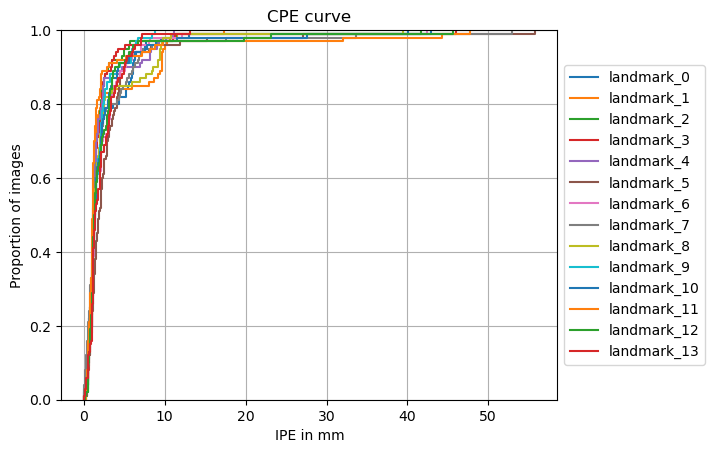

In [15]:
from landmarker.visualize import plot_cpe

plot_cpe(true_landmarks_test, pred_landmarks_test, dim=dim_img, dim_orig=dim_origs_test.int(),
                    pixel_spacing=pixel_spacings_test, padding=paddings_test, class_names=ds_test.class_names,
                    group=False, title="CPE curve", save_path=None,
                    stat='proportion', unit='mm', kind='ecdf')